<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-final-project/blob/main/dtsa5511_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bank of Canada interest rate changes
DTSA5511 final project


In [1]:
!pip install scikit-learn-intelex -q
!pip install scikeras -q

In [50]:
# file handling & general
import itertools
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')
from functools import reduce

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# ml
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


## 1 Introduction

This project was first created for dtsa 5506, data mining pipeling project. It initially compared a few supervised models and some unsupervised/clustering models, with a brief attempt at a neural network. This updated version of this project is to use deep learning to predict Bank of Canada interest rate changes before they are announced. Interest rates affect nearly everyone and changes to the prevailing rates affect many decisions not just in the long term, but in the short term as well.

The bank of canada exercises counter-inflationary monetary policy by increasing interest to slow inflation, and decreasing interest to allow to avoid recession. To predict changes to the policy interest rate, it would be helpful to first model and predict inflation. The consumer price index is a common measure of inflation, and cpi time series is available from statistics canada.

The use of deep learning is a fairly new tool for central banks in the last decade. Deep learning allows hundreds or even thousands of variables to be used in prediction models.

This project is a classification? Regression? problem that involves time series, so will reuire the use of an LSTM or GRU


### 1.1 The data

In [3]:
# boc rate announcement dates, incl 2025
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/rate-announcements.csv'
#url = None
rate_announcements = pd.read_csv(url)
rate_announcements.tail(8)

,date
193,2025-01-29
194,2025-03-12
195,2025-04-16
196,2025-06-04
197,2025-07-30
198,2025-09-17
199,2025-10-29
200,2025-12-10


In [4]:
# function to preprocess features
def preprocess_rate_announcements(rate_announcements):
    '''
    peprocesses rate announcement data by:
    - parsing dates
    - normalizing them to the first day of the month
    - creating a binary 'announcement' column
    - renaming 'date' to 'Date'

    Args:
        rate_announcements (pd.DataFrame): df containing 'date' column.

    Returns:
        pd.DataFrame: df with 'Date' column (monthly), and an 'announcement' column.
    '''

    # check if date exists
    if 'date' not in rate_announcements.columns:
        raise ValueError('input df must contain a "date" column')

    rate_announcements['date'] = pd.to_datetime(rate_announcements['date'])

    # normalize to first day of month
    rate_announcements['Date'] = (rate_announcements['date'].dt.to_period('M')
                                                            .dt.to_timestamp())

    # add binary flag for announcem ent
    rate_announcements['announcement'] = 1

    # drop duplicates
    rate_announcements = rate_announcements.drop_duplicates(subset = 'Date')

    # keep relevant columns
    return rate_announcements[['Date', 'announcement']]

In [5]:
rate_announcements = preprocess_rate_announcements(rate_announcements)
rate_announcements.head()

,Date,announcement
0,2001-01-01,1
1,2001-03-01,1
2,2001-04-01,1
3,2001-05-01,1
4,2001-07-01,1


The data was mined from the Statistics Canada database using XLM

In [6]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}

Some data series are reported daily, other series are reported monthly, quarterly or annually. To address the various reporting periods, I need a method to fill the NA values.

In [7]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''Initialize with a dataframe of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''Extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''Transform the XML response into a structured DataFrame'''
        root = ET.fromstring(xml_content)
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # Convert date format
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''Convert quarterly date string (YYYY-Qx) to standard YYYY-MM format'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''Load df into global object with name `name` (e.g., wage, rmpi)'''
        globals()[name] = df
        self.data_objects[name] = df
        print(f'Data for {name} saved to object {name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')


My data mining project included:
* wages
* raw materials price index
* consumer price index
* rate - target

Add?:

Housing starts 34-10-0156 v52299896

Building permits 34-10-0292 v1675119645 avail > 2018-01 only

Retail trade 20-10-0067 v1446870183

Unemployment rate 14-10-0287 v2062815

Employment rate 14-10-0287 v2062817

Labour force participation rate 14-10-0287 v2062816

GDP all industries 36-10-0434 v65201210

manufacturing Industrial Production index 18-10-0267 v1230996350

manufacturing Capacity utilization rate 16-10-0015 v1707053279

1 trading partner US exchange rate 33-10-0036 v111666248 avail > 2017-01

2 trading partner Chinese renminbi exchange rate 33-10-0036 v111666226 avail > 2017-01

3 trading partner Euro 33-10-0036 v111666227 avail > 2017-01

4 trading partner Japanese yen 33-10-0036 v111666231 avail > 2017-01

S&P TSX composite close 10-10-0125 v122620

# nts: to get the table with vector ids, need to select 'download selected data (for database loading)'

In [8]:
# metadata - info to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi',
             'house_st', # removed building permits & retail
             'unemp', 'empl', 'lab_part',
             'gdp', 'mf_ipi', # removed mf_cap
             'us_fx', 'cn_fx', 'eu_fx',
             'jp_fx', 'tsx_cl', 'rate'],
    'tableid': [14100223, 18100268, 18100004,
                34100156,  # removed building permits & retail
                14100287, 14100287, 14100287,
                36100434, 18100267, # removed mf_cap
                33100036, 33100036, 33100036,
                33100036, 10100125, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seas adj, 2002 = 100',
                  'housing starts',
                  'unemployment rate',
                  'employment rate',
                  'labour force participation rate',
                  'gross domestic product',
                  'manufacturing indust prod idx',
                  'usd exchange rate',
                  'china renminbi exchange rate',
                  'euro exchange rate',
                  'japan yen exchange',
                  's&p tsx close',
                  'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973',
               'v52299896', # removed bldg & retail
               'v2062815', 'v2062817', 'v2062816',
               'v65201210', 'v1230996350', # removed mf_cap
               'v111666275', 'v111666253', 'v111666254',
               'v111666258', 'v122620', 'v39078'],
    'frequency': ['monthly', 'monthly', 'monthly',
                  'monthly', # removed bldg & retail
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', # removed mf_cap
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', 'daily'],
    'start': ['2001-01', '2001-01', '2001-01',
              '2001-01', # removed bldg & retail
              '2001-01','2001-01', '2001-01',
              '2001-01','2001-01', # removed mf_cap
              '2017-01-01', '2017-01-01', '2017-01-01',
              '2017-01-01', '2001-01-01', '2001-01-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12',
            '2024-12', # removed bldg & retail
            '2024-12', '2024-12', '2024-12',
            '2024-12', '2024-12', # removed mf_cap
            '2024-12-31', '2024-12-31', '2024-12-31',
            '2024-12-31', '2024-12', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [9]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage
Processing rmpi...
Data for rmpi saved to object rmpi
Processing cpi...
Data for cpi saved to object cpi
Processing house_st...
Data for house_st saved to object house_st
Processing unemp...
Data for unemp saved to object unemp
Processing empl...
Data for empl saved to object empl
Processing lab_part...
Data for lab_part saved to object lab_part
Processing gdp...
Data for gdp saved to object gdp
Processing mf_ipi...
Data for mf_ipi saved to object mf_ipi
Processing us_fx...
Data for us_fx saved to object us_fx
Processing cn_fx...
Data for cn_fx saved to object cn_fx
Processing eu_fx...
Data for eu_fx saved to object eu_fx
Processing jp_fx...
Data for jp_fx saved to object jp_fx
Processing tsx_cl...
Data for tsx_cl saved to object tsx_cl
Processing rate...
Data for rate saved to object rate


In [10]:
# check if data loaded correctly
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3), '\n')

wage
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14 

rmpi
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5 

cpi
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1 

house_st
      Date    Value
0  2001-01  141.470
1  2001-02  126.744
2  2001-03  131.271 

unemp
      Date  Value
0  2001-01    6.9
1  2001-02    7.0
2  2001-03    7.1 

empl
      Date  Value
0  2001-01   61.4
1  2001-02   61.3
2  2001-03   61.2 

lab_part
      Date  Value
0  2001-01   65.9
1  2001-02   65.9
2  2001-03   66.0 

gdp
      Date      Value
0  2001-01  1434295.0
1  2001-02  1433843.0
2  2001-03  1434685.0 

mf_ipi
      Date  Value
0  2001-01   77.1
1  2001-02   77.5
2  2001-03   77.8 

us_fx
      Date   Value
0  2017-01  1.3193
1  2017-02  1.3107
2  2017-03  1.3386 

cn_fx
      Date   Value
0  2017-01  0.1914
1  2017-02  0.1907
2  2017-03  0.1941 

eu_fx
      Date   Value
0  2017-01  1.4028
1  2017-02  1.3951
2  2017-03  1.4307 



In [11]:
# variable list for plt
variables = ['wage', 'rmpi', 'cpi', 'house_st', # removed bldg & retail
             'unemp', 'empl', 'lab_part', 'gdp', 'mf_ipi', # removed mf_cap
             'us_fx', 'cn_fx', 'eu_fx', 'jp_fx', 'tsx_cl', 'rate']

daily = ['tsx_cl']

def rename_value_column(vars_list):
    ''' rename "Value" column to variable name'''
    for var in vars_list:
        df = globals()[var]
        df.rename(columns={'Value': var},
                  inplace = True)

def convert_daily_to_monthly(daily_vars):
    ''' convert daily dataframes to monthly avgs '''
    for var in daily_vars:
        df = globals()[var].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = (df['Date'].dt.to_period('M')
                                 .dt.to_timestamp())
        df_monthly = (df.groupby('Month', as_index = False)[var]
                        .mean())
        df_monthly.rename(columns = {'Month': 'Date'},
                          inplace=True)
        globals()[var] = df_monthly

def preprocess_rate(rate_df):
    ''' cleans and transforms daily interest rate DataFrame to monthly,
    applying the new rate to the first day of the month of change
    '''
    rate_df['Date'] = pd.to_datetime(rate_df['Date'])
    rate_df['rate'] = pd.to_numeric(rate_df['rate'],
                                    errors = 'coerce')

    rate_df = rate_df.sort_values('Date')
    rate_df['prev_rate'] = rate_df['rate'].shift(1)
    rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']

    rate_changes = rate_df[rate_df['rate_changed']].copy()
    rate_changes['Date'] = (rate_changes['Date'].dt.to_period('M')
                                                .dt.to_timestamp())
    rate_changes = (rate_changes.groupby('Date')['rate']
                                .last()
                                .reset_index())
    monthly_rate_df = (rate_changes.set_index('Date')
                                   .resample('MS')
                                   .ffill()
                                   .reset_index())
    return monthly_rate_df

def ensure_date_datetime(vars_list):
    ''' ensure all 'Date' columns are datetime dtype '''
    for var in vars_list:
        df = globals()[var]
        df['Date'] = pd.to_datetime(df['Date'])

def merge_on_date(vars_list):
    ''' mrge all dataframes on 'Date' column using outer join '''
    dfs = [globals()[var] for var in vars_list]
    merged = reduce(lambda left,
                    right: pd.merge(left,
                                    right,
                                    on = 'Date',
                                    how = 'outer'), dfs)
    return merged

In [12]:
# rename value cols
rename_value_column(variables)

# daily FX and equity series to monthly
convert_daily_to_monthly(daily)

# preprocess rate series
rate = preprocess_rate(rate)

# date cols are datetime
ensure_date_datetime(variables)

# merge on date
data = merge_on_date(variables)

The interest rate data is published (almost) daily, but only changes at 8 pre-determined dates per year. This will require some extra wrangling to align with the other monthly series. Where there is a rate change, I'll apply changed rate to that entire month, effective on the 1st day, so that rate_df can be aligned with the rate announcement data.

In [13]:
# Ensure 'Date' columns are datetime
data['Date'] = pd.to_datetime(data['Date'])
rate_announcements['Date'] = pd.to_datetime(rate_announcements['Date'])

# Merge on 'Date'
merged_data = pd.merge(data, rate_announcements, on='Date', how='left')

# Fill missing values in 'announcement' column with 0
merged_data['announcement'] = merged_data['announcement'].fillna(0).astype(int)

# Optional: set 'Date' as index
merged_data = merged_data.set_index('Date')

In [14]:
print(data.head(2))

        Date    wage  rmpi   cpi  house_st  unemp  empl  lab_part        gdp  \
0 2001-01-01  657.14  65.2  96.3   141.470    6.9  61.4      65.9  1434295.0   
1 2001-02-01  653.59  65.8  96.8   126.744    7.0  61.3      65.9  1433843.0   

   mf_ipi  us_fx  cn_fx  eu_fx  jp_fx   tsx_cl  rate  
0    77.1    NaN    NaN    NaN    NaN  9321.87  5.75  
1    77.5    NaN    NaN    NaN    NaN  8078.72  5.75  


In [15]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      288 non-null    datetime64[ns]
 1   wage      288 non-null    float64       
 2   rmpi      288 non-null    float64       
 3   cpi       288 non-null    float64       
 4   house_st  288 non-null    float64       
 5   unemp     288 non-null    float64       
 6   empl      288 non-null    float64       
 7   lab_part  288 non-null    float64       
 8   gdp       288 non-null    float64       
 9   mf_ipi    288 non-null    float64       
 10  us_fx     96 non-null     float64       
 11  cn_fx     96 non-null     float64       
 12  eu_fx     96 non-null     float64       
 13  jp_fx     96 non-null     float64       
 14  tsx_cl    273 non-null    float64       
 15  rate      288 non-null    float64       
dtypes: datetime64[ns](1), float64(15)
memory usage: 36.1 KB
None


* we have 288 months of data
* retail, mf_cap, unavailable from stats can before 2017 - dropped
* building permits series unavailable from stats can before 2018 - dropped
* tsx_cl only avail from stats can until sept 2023 - need to append .csv from yahoo finance.
* fx rates only available from 2017 onwards from stats can. get this info from boc

In [16]:
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/fx-2001-2016%20-%20fx-2001-2017.csv'
hist_fx = pd.read_csv(url)
hist_fx['Date'] = pd.to_datetime(hist_fx['date'])
hist_fx = hist_fx.drop(columns=['date'])
hist_fx.tail()

,cn_fx,eu_fx,jp_fx,us_fx,Date
187,0.1954,1.4563,0.01284,1.299323,2016-08-01
188,0.1965,1.4704,0.01288,1.310233,2016-09-01
189,0.1968,1.4594,0.01275,1.325305,2016-10-01
190,0.1963,1.4486,0.01238,1.343990,2016-11-01
191,0.1926,1.4060,0.01150,1.333565,2016-12-01


In [17]:
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/tsx_cl-2023-2024.csv'

hist_tsx = pd.read_csv(url)
hist_tsx['tsx_cl'] = hist_tsx['tsx_cl'].str.replace(',', '').astype(float)
hist_tsx['Date'] = pd.to_datetime(hist_tsx['Date'])
hist_tsx['Month'] = hist_tsx['Date'].dt.to_period('M').dt.to_timestamp()

# Group by 'Month' and compute the average (assuming closing value is in 'tsx_cl' column)
tsx_monthly = hist_tsx.groupby('Month', as_index=False)['tsx_cl'].mean()

# Optional: rename 'Month' to 'Date' for consistency
tsx_monthly.rename(columns={'Month': 'Date'}, inplace=True)

# Preview result
print(tsx_monthly.head())
tsx_monthly.head()

        Date        tsx_cl
0 2023-10-01  19204.652381
1 2023-11-01  19897.900000
2 2023-12-01  20590.873684
3 2024-01-01  20976.054545
4 2024-02-01  21116.205000


,Date,tsx_cl
0,2023-10-01,19204.652381
1,2023-11-01,19897.900000
2,2023-12-01,20590.873684
3,2024-01-01,20976.054545
4,2024-02-01,21116.205000


In [18]:
# merge hist_fx into data
data = pd.merge(merged_data,
                hist_fx,
                on = 'Date',
                how = 'outer',
                suffixes = ('', '_hist'))

# fill missing fx rates from historical
fx_vars = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']

for var in fx_vars:
    hist_col = f'{var}_hist'
    if hist_col in data.columns:
        data[var] = data[var].fillna(data[hist_col])
        data.drop(columns = hist_col,
                  inplace = True)

print(data.head())

        Date    wage  rmpi   cpi  house_st  unemp  empl  lab_part        gdp  \
0 2001-01-01  657.14  65.2  96.3   141.470    6.9  61.4      65.9  1434295.0   
1 2001-02-01  653.59  65.8  96.8   126.744    7.0  61.3      65.9  1433843.0   
2 2001-03-01  655.14  65.5  97.1   131.271    7.1  61.2      66.0  1434685.0   
3 2001-04-01  652.44  65.2  97.8   144.474    7.1  61.3      66.0  1433399.0   
4 2001-05-01  652.28  65.3  98.6   139.901    7.0  61.3      66.0  1439506.0   

   mf_ipi     us_fx   cn_fx   eu_fx     jp_fx   tsx_cl  rate  announcement  
0    77.1  1.502864  0.1816  1.4099  0.012875  9321.87  5.75             1  
1    77.5  1.523125  0.1839  1.4008  0.013096  8078.72  5.75             0  
2    77.8  1.558441  0.1883  1.4154  0.012829  7608.00  5.25             1  
3    78.2  1.558495  0.1882  1.3906  0.012588  7946.63  5.00             1  
4    78.5  1.541123  0.1862  1.3482  0.012670  8161.87  4.75             1  


In [19]:
print(tsx_monthly.columns)
print(tsx_monthly.head())


Index(['Date', 'tsx_cl'], dtype='object')
        Date        tsx_cl
0 2023-10-01  19204.652381
1 2023-11-01  19897.900000
2 2023-12-01  20590.873684
3 2024-01-01  20976.054545
4 2024-02-01  21116.205000


In [20]:
# reset inx
data = data.reset_index()

# date columns format
data['Date'] = (pd.to_datetime(data['Date']).dt.to_period('M').dt.to_timestamp())
tsx_monthly['Date'] = (pd.to_datetime(tsx_monthly['Date']).dt.to_period('M').dt.to_timestamp())

# merge tsx vals
data = pd.merge(data, tsx_monthly,
                on = 'Date',
                how = 'left',
                suffixes = ('', '_new'))

# use new tsx_cl vals
data['tsx_cl'] = data['tsx_cl_new'].combine_first(data['tsx_cl'])


data.drop(columns = ['tsx_cl_new'], inplace=True)

# reset idx
data = data.set_index('Date')

print(data.loc['2023-09-01':'2024-02-01', ['tsx_cl']])

                  tsx_cl
Date                    
2023-09-01  19541.270000
2023-10-01  19204.652381
2023-11-01  19897.900000
2023-12-01  20590.873684
2024-01-01  20976.054545
2024-02-01  21116.205000


In [21]:
data.head()

,index,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
Date,,,,,,,,,,,,,,,,,
2001-01-01,0,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,77.1,1.502864,0.1816,1.4099,0.012875,9321.87,5.75,1
2001-02-01,1,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,77.5,1.523125,0.1839,1.4008,0.013096,8078.72,5.75,0
2001-03-01,2,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,77.8,1.558441,0.1883,1.4154,0.012829,7608.00,5.25,1
2001-04-01,3,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,78.2,1.558495,0.1882,1.3906,0.012588,7946.63,5.00,1
2001-05-01,4,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,78.5,1.541123,0.1862,1.3482,0.012670,8161.87,4.75,1


In [22]:
# descriptive stats
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2001-01-01 to 2024-12-01
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         288 non-null    int64  
 1   wage          288 non-null    float64
 2   rmpi          288 non-null    float64
 3   cpi           288 non-null    float64
 4   house_st      288 non-null    float64
 5   unemp         288 non-null    float64
 6   empl          288 non-null    float64
 7   lab_part      288 non-null    float64
 8   gdp           288 non-null    float64
 9   mf_ipi        288 non-null    float64
 10  us_fx         288 non-null    float64
 11  cn_fx         288 non-null    float64
 12  eu_fx         288 non-null    float64
 13  jp_fx         288 non-null    float64
 14  tsx_cl        288 non-null    float64
 15  rate          288 non-null    float64
 16  announcement  288 non-null    int64  
dtypes: float64(15), int64(2)
memory usage: 48.6 KB


In [23]:
data.describe()

,index,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,143.500000,911.699514,99.124653,123.738542,191.275632,6.979167,61.790625,66.427778,1.836635e+06,94.009722,1.239341,0.175529,1.465478,0.011273,13705.173079,2.242188,0.666667
std,83.282651,170.201881,24.301023,17.143681,31.992781,1.169822,1.211767,0.915636,2.395457e+05,15.301474,0.164430,0.020802,0.090064,0.001255,4202.143176,1.522531,0.472225
min,0.000000,652.280000,55.300000,96.300000,95.831000,4.800000,51.900000,60.100000,1.433233e+06,74.800000,0.955770,0.130000,1.230700,0.008420,6180.420000,0.500000,0.000000
25%,71.750000,772.157500,84.075000,109.775000,173.356250,6.200000,61.400000,65.800000,1.656228e+06,82.275000,1.091370,0.155500,1.406375,0.010247,11227.772500,1.000000,0.000000
50%,143.500000,903.520000,97.050000,122.200000,189.005500,7.000000,61.800000,66.300000,1.806828e+06,92.000000,1.264557,0.184550,1.464800,0.011580,13540.580000,1.750000,1.000000
75%,215.250000,1009.772500,112.725000,134.225000,209.608000,7.500000,62.400000,67.200000,2.042136e+06,99.625000,1.342275,0.192825,1.533150,0.012225,16028.565000,3.250000,1.000000
max,287.000000,1291.170000,166.600000,162.100000,290.954000,14.200000,63.600000,67.700000,2.285235e+06,132.700000,1.599618,0.216300,1.680700,0.013600,25187.447368,5.750000,1.000000


In [24]:
data.reset_index(inplace = True)


In [25]:
data.drop(columns = 'index',
          inplace  = True)
data.head(2)

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,77.1,1.502864,0.1816,1.4099,0.012875,9321.87,5.75,1
1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,77.5,1.523125,0.1839,1.4008,0.013096,8078.72,5.75,0


for plotting, data will need to be scaled

In [26]:
numeric_cols = data.columns.drop('Date')

#  scaling
scaler = StandardScaler()
scaled_array = scaler.fit_transform(data[numeric_cols])

# Create scaled DataFrame with same column names and original 'Date'
data_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)
data_scaled.insert(0, 'Date', data['Date'])  # Add Date column back


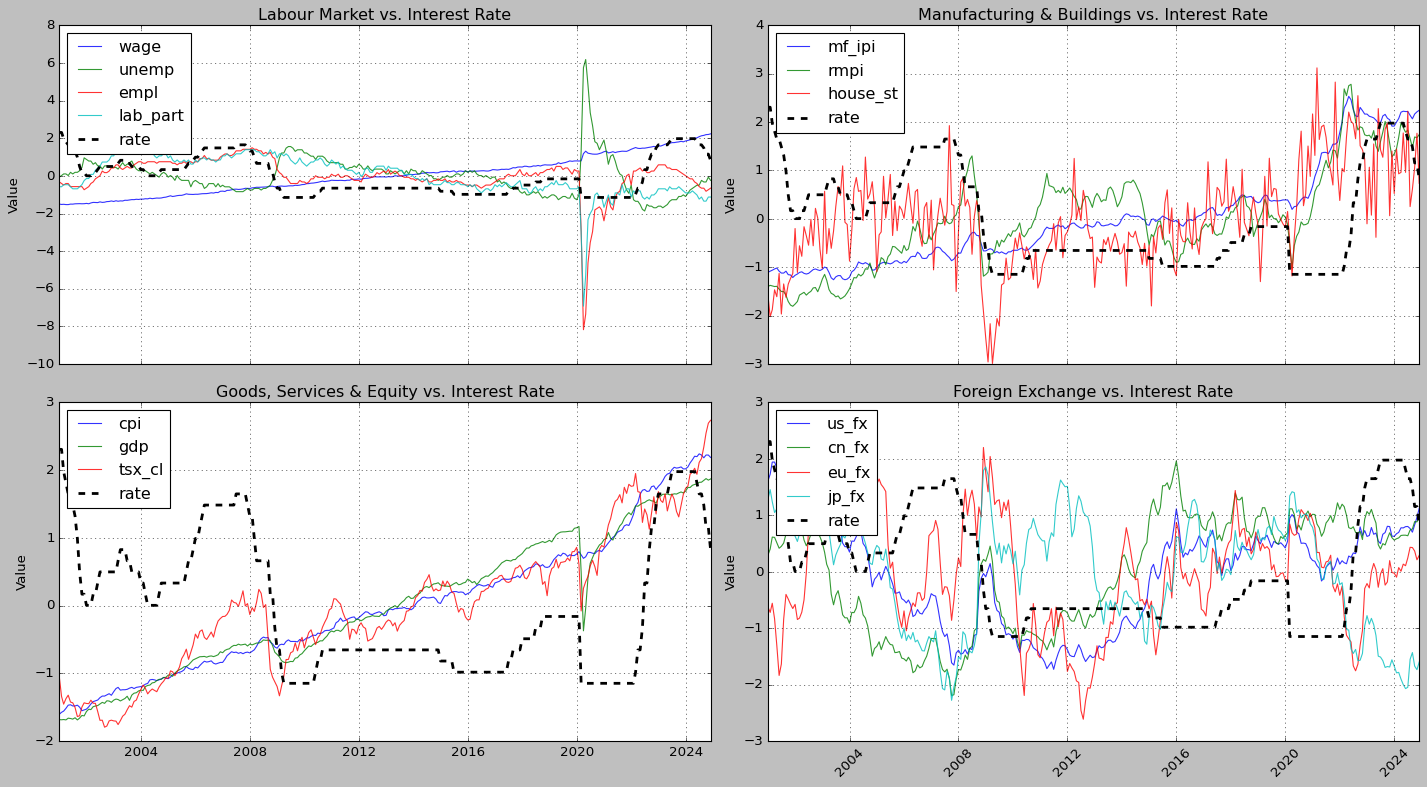

In [27]:
# Set plotting style
plt.style.use('classic')

# Groups of variables
labour_vars = ['wage', 'unemp', 'empl', 'lab_part']
mf_vars     = ['mf_ipi', 'rmpi', 'house_st']
gs_vars     = ['cpi', 'gdp', 'tsx_cl']
fx_vars     = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']
groups = {
    'Labour Market': labour_vars,
    'Manufacturing & Buildings': mf_vars,
    'Goods, Services & Equity': gs_vars,
    'Foreign Exchange': fx_vars
}

# Plot each group with 'rate'
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, (title, vars_) in enumerate(groups.items()):
    ax = axes[i]

    # Plot each variable in the group
    for var in vars_:
        ax.plot(data_scaled['Date'], data_scaled[var], label=var, alpha=0.8)

    # Plot 'rate' on the same axis (or use a twin axis if needed)
    ax.plot(data_scaled['Date'], data_scaled['rate'], label='rate', color='black', linewidth=2.5, linestyle='--')

    ax.set_title(f'{title} vs. Interest Rate')
    ax.set_ylabel('Value')
    ax.legend(loc='upper left')
    ax.grid(True)

# Format x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
exclude_cols = ['Date', 'rate', 'announcement']
feature_cols = [col for col in data.columns if col not in exclude_cols]

correlation_matrix = data[feature_cols + ['rate']].corr()
rate_correlation = correlation_matrix['rate'].drop(labels=['rate']).sort_values(ascending=False)

print(rate_correlation)


empl        0.426305
us_fx       0.255054
lab_part    0.200855
house_st    0.161438
eu_fx       0.055311
rmpi        0.050729
mf_ipi      0.048921
tsx_cl      0.007106
cpi        -0.044501
gdp        -0.103649
wage       -0.118164
cn_fx      -0.256279
unemp      -0.458009
jp_fx      -0.503754
Name: rate, dtype: float64


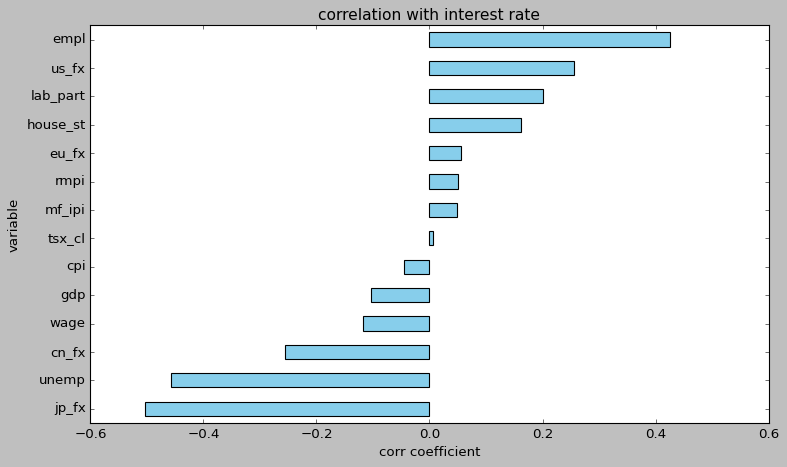

In [29]:
# plot correlations

plt.style.use('classic')

plt.figure(figsize=(10, 6))
rate_correlation.plot(kind = 'barh',
                      color = 'skyblue',
                      edgecolor = 'black')
plt.title('correlation with interest rate',
          fontsize = 14)
plt.xlabel('corr coefficient')
plt.ylabel('variable')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

While some variables show very little correlation with the corresponding interest rate, more patterns will show up when lagged variables are included. The interest rate decisions the central bank makes are rarely based on the current month's data, but on the data from the previous months. It also takes time for effects from changes in something like the raw materials price index and foreign exchange rates to trickle down through the manufacturing sector and into retail sales and the consumer price index.

Something I found interesting here is that the chinese fx and japanese fx are negatively correlated with the interest rate, but the US fx are positively correlated with the interest rate. Canadian commodities are priced in USD when sold in global markets, interesting to see the difference here.

### Feature engineering

In [30]:
ml_df = data.copy()
ml_df = ml_df.reset_index()

In [31]:
# categorical target - rate_change
ml_df['rate_diff'] = ml_df['rate'].diff().fillna(0)
ml_df['rate_change'] = ml_df['rate_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

ml_df['rate_change'].unique()

array([ 0, -1,  1])

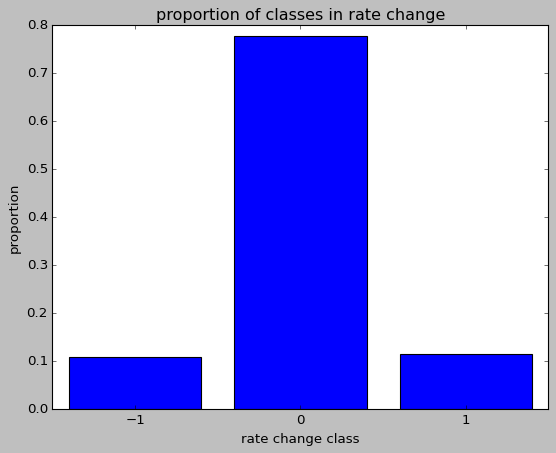

In [32]:
plt.style.use('classic')
# plot class proportions
rate_change_counts = ml_df['rate_change'].value_counts()
proportions = rate_change_counts / len(ml_df)

plt.figure(figsize = (8, 6))
plt.bar(proportions.index,
        proportions.values)
plt.xlabel('rate change class')
plt.ylabel('proportion')
plt.title('proportion of classes in rate change')
plt.xticks(proportions.index)
plt.show()

In [33]:
print(proportions)

rate_change
 0    0.777778
 1    0.114583
-1    0.107639
Name: count, dtype: float64


the classes are certainly imbalanced, with 'no change' dominating. Increase and decrease classes look fairly balanced against each other

In [34]:
ml_df['Date'] = pd.to_datetime(ml_df['Date'])

Can an LSTM pick up on seasonal trends? Yes, but having a month and quarter indicator can assist in picking up trends.

In [35]:
# date features
ml_df['year'] = ml_df['Date'].dt.year
ml_df['month'] = ml_df['Date'].dt.month
ml_df['quarter'] = ml_df['Date'].dt.quarter

https://www.bankofcanada.ca/rates/indicators/key-variables/inflation-control-target/

In [36]:
ml_df['cpi_pctchg12'] = ml_df['cpi'].pct_change(periods=12) * 100  # % inflation over 12 months
ml_df['cpi_dev'] = ml_df['cpi_pctchg12'] - 2.0

In [37]:
# deviation from target inflation rate
ml_df['cpi_target_dev'] = ml_df['cpi'] - 2.0

ml_df['interest_rate_dev_outside_band'] = ml_df['rate'].apply(lambda x: 0 if 1.0 <= x <= 3.0 else (1.0 - x if x < 1.0 else x - 3.0)
 )

In [38]:
ml_df.shape

(288, 27)

In [39]:
# need to add deviations from the mean
# remove trend lags?

def create_lag_features(df, feature_list,
                        pct_windows=[1,3,12],
                        ema_spans=[3,6,9],
                        rolling_std_windows=[3,6],
                        rolling_mean_windows=[3,6]):
    """
    Efficiently creates lagged and derived features using pd.concat.
    """

    df_new = df.copy()
    new_feature_list = []

    for feat in feature_list:
        # Percent changes
        for w in pct_windows:
            colname = f'{feat}_pctchg{w}'
            new_feature_list.append(df_new[feat].pct_change(periods = w)
                                                .rename(colname))

        # EMAs
        for span in ema_spans:
            colname = f'{feat}_ema{span}'
            new_feature_list.append(df_new[feat].ewm(span = span,
                                                     adjust = False)
                                                 .mean()
                                                 .rename(colname))

        # rolling std dev (volatility)
        for w in rolling_std_windows:
            colname = f'{feat}_rolling_std{w}'
            new_feature_list.append(df_new[feat].rolling(window = w)
                                                .std()
                                                .rename(colname))

        # dev from rolling mean
        for w in rolling_mean_windows:
            roll_mean_col = f'{feat}_rolling_mean{w}'
            roll_mean_series = (df_new[feat].rolling(window = w)
                                            .mean()
                                            .rename(roll_mean_col))
            dev_col = f'{feat}_diff_rolling_mean{w}'
            deviation_series = (df_new[feat] - roll_mean_series).rename(dev_col)

            new_feature_list.append(roll_mean_series)
            new_feature_list.append(deviation_series)

        # trend (diff of dev from longest rolling mean) - calculate after all other features for this variable
        dev_col_name = f'{feat}_diff_rolling_mean{max(rolling_mean_windows)}'

        # Find the deviation series in the new_feature_list
        dev_series = next((s for s in new_feature_list if s.name == dev_col_name), None)
        if dev_series is not None:
             trend_series = dev_series.diff().rename(f'{feat}_trend')
             new_feature_list.append(trend_series)


    # concat new features
    engineered_features = pd.concat(new_feature_list, axis = 1)
    df_new = pd.concat([df_new, engineered_features], axis = 1)

    return df_new

 wage          288 non-null    float64
 2   rmpi          288 non-null    float64
 3   cpi           288 non-null    float64
 4   house_st      288 non-null    float64
 5   unemp         288 non-null    float64
 6   empl          288 non-null    float64
 7   lab_part      288 non-null    float64
 8   gdp           288 non-null    float64
 9   mf_ipi        288 non-null    float64
 10  us_fx         288 non-null    float64
 11  cn_fx         288 non-null    float64
 12  eu_fx         288 non-null    float64
 13  jp_fx         288 non-null    float64
 14  tsx_cl        288 non-null    float64
 15  rate          288 non-null    float64
 16  announcement  288 non-null    int64  

In [40]:
features_list = ['wage',
                 'rmpi',
                 'cpi',
                 'house_st',
                 'unemp',
                 'empl',
                 'lab_part',
                 'gdp',
                 'mf_ipi',
                 'us_fx',
                 'cn_fx',
                 'eu_fx',
                 'jp_fx',
                 'tsx_cl'
                 ]

In [41]:
ml_df = create_lag_features(ml_df, features_list)

In [42]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Columns: 209 entries, index to tsx_cl_trend
dtypes: datetime64[ns](1), float64(202), int32(3), int64(3)
memory usage: 467.0 KB


Now that lag features have been added, there will be some NA values in the first year of the data. These rows will need to be cut

In [43]:
ml_df[ml_df.isna().any(axis = 1)]

,index,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,...,tsx_cl_ema3,tsx_cl_ema6,tsx_cl_ema9,tsx_cl_rolling_std3,tsx_cl_rolling_std6,tsx_cl_rolling_mean3,tsx_cl_diff_rolling_mean3,tsx_cl_rolling_mean6,tsx_cl_diff_rolling_mean6,tsx_cl_trend
0,0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,...,9321.870000,9321.870000,9321.870000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,...,8700.295000,8966.684286,9073.240000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2001-03-01,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,...,8154.147500,8578.488776,8780.192000,885.470649,NaN,8336.196667,-728.196667,NaN,NaN,NaN
3,3,2001-04-01,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,...,8050.388750,8397.957697,8613.479600,242.794619,NaN,7877.783333,68.846667,NaN,NaN,NaN
4,4,2001-05-01,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,...,8106.129375,8330.504069,8523.157680,279.216317,NaN,7905.500000,256.370000,NaN,NaN,NaN
5,5,2001-06-01,656.81,63.9,98.7,155.286,7.2,61.1,65.9,1438295.0,...,7921.239688,8160.745764,8365.796144,212.764818,613.900547,7948.283333,-211.933333,8142.240000,-405.890000,NaN
6,6,2001-07-01,656.43,62.7,98.4,128.469,7.1,61.1,65.8,1436172.0,...,7805.464844,8026.158403,8230.574915,260.191717,225.229681,7862.636667,-172.946667,7870.210000,-180.520000,225.370000
7,7,2001-08-01,659.47,62.7,98.4,148.331,7.2,61.1,65.8,1440974.0,...,7602.342422,7847.033145,8064.303932,182.668467,266.474701,7608.420000,-209.200000,7756.960000,-357.740000,-177.220000
8,8,2001-09-01,659.90,60.8,98.6,139.504,7.2,61.1,65.8,1433233.0,...,7220.451211,7558.897961,7819.155146,432.653582,464.250002,7309.156667,-470.596667,7628.720000,-790.160000,-432.420000
9,9,2001-10-01,660.91,57.7,98.1,148.167,7.3,61.1,65.9,1439780.0,...,7053.075605,7366.555686,7632.464117,310.983549,517.891275,7041.160000,-155.460000,7451.898333,-566.198333,223.961667


In [44]:
ml_df = ml_df.dropna()

In [45]:
ml_df.drop(columns = 'index',
           inplace = True)


ml_df.head(2)

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,...,tsx_cl_ema3,tsx_cl_ema6,tsx_cl_ema9,tsx_cl_rolling_std3,tsx_cl_rolling_std6,tsx_cl_rolling_mean3,tsx_cl_diff_rolling_mean3,tsx_cl_rolling_mean6,tsx_cl_diff_rolling_mean6,tsx_cl_trend
12,2002-01-01,663.15,56.4,97.6,184.910,8.0,61.0,66.3,1463177.0,76.2,...,7556.188201,7521.407233,7618.148428,141.594544,369.128155,7587.516667,60.973333,7314.338333,334.151667,-33.053333
13,2002-02-01,659.88,57.7,98.2,155.942,7.9,61.1,66.3,1471175.0,76.6,...,7596.844100,7554.576595,7622.018742,26.789969,392.184561,7658.133333,-20.633333,7354.051667,283.448333,-50.703333


## LSTM Model

In [46]:
# labels: -1, 0, 1 to 0, 1, 2
rate_change_shifted = ml_df['rate_change'] + 1

# prep features
X = ml_df.drop(columns = ['rate', 'rate_change'])
X = X.select_dtypes(exclude = ['datetime64[ns]', 'datetime64[ns, UTC]'])  # Drop date columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split data
split_point = int(len(X_scaled) * 0.8)
X_train = X_scaled[:split_point]
X_test  = X_scaled[split_point:]

# split target
rate_train = rate_change_shifted[:split_point]
rate_test  = rate_change_shifted[split_point:]

y_train_labels = rate_train.to_numpy()

# encode target
y_train = to_categorical(y_train_labels, num_classes=3)
y_test  = to_categorical(rate_test.to_numpy(), num_classes=3)




In [47]:
# create sequences
def create_sequences(X, y, time_steps = 12):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])

        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train,
                                            y_train,
                                            time_steps)
X_test_seq, y_test_seq = create_sequences(X_test,
                                          y_test,
                                          time_steps)

print('X_train_seq shape:', X_train_seq.shape)
print('y_train_seq shape:', y_train_seq.shape)

X_train_seq shape: (208, 12, 205)
y_train_seq shape: (208, 3)


In [48]:
 # imbalanced class weights
weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(y_train_labels),
                                            y = y_train_labels)

weights = np.clip(weights, 0.5, 2.0)

class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(2.0), 1: np.float64(0.5), 2: np.float64(2.0)}


In [51]:
# model
K.clear_session()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                     clipnorm = 1.0)

model1 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),
    LSTM(64, return_sequences = False),
    Dropout(0.2),
    Dense(32,
          activation = 'relu'),
    Dense(3,
          activation = 'softmax')
])

model1.compile(loss = 'categorical_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])

In [52]:
# train
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 5,
                           restore_best_weights = True)

history1 = model1.fit(X_train_seq,
                      y_train_seq,
                      epochs = 30,
                      batch_size = 16,
    validation_data = (X_test_seq,
                       y_test_seq),
    class_weight = class_weights,
    callbacks = [early_stop])

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4597 - loss: 0.8455 - val_accuracy: 0.5000 - val_loss: 0.9866
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8023 - loss: 0.6630 - val_accuracy: 0.4773 - val_loss: 0.9874
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7935 - loss: 0.4966 - val_accuracy: 0.4773 - val_loss: 0.9973
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8198 - loss: 0.4443 - val_accuracy: 0.4318 - val_loss: 0.9904
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8686 - loss: 0.3525 - val_accuracy: 0.4318 - val_loss: 0.9908
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8306 - loss: 0.3796 - val_accuracy: 0.4545 - val_loss: 0.9945


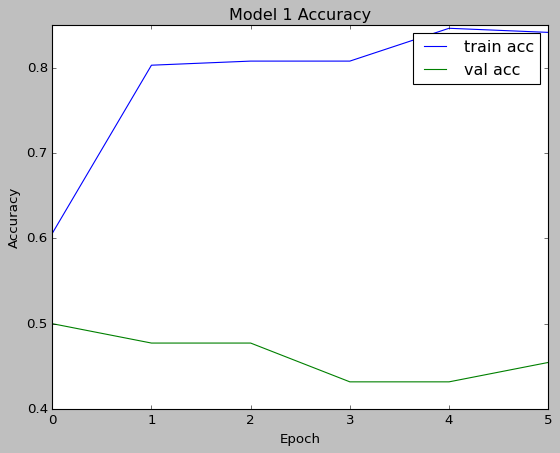

In [53]:
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 1 Accuracy')
plt.show()

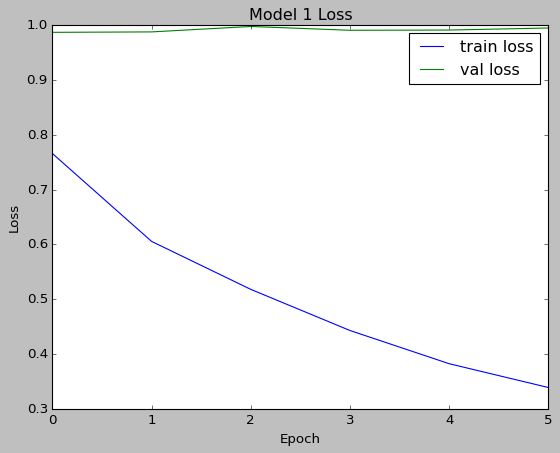

In [54]:
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 1 Loss')
plt.show()

Model 1 shows signs of overfitting - the validation accuracy is significantly lower than training accuracy.

In [55]:
K.clear_session()

model2 = Sequential([Input(shape = (X_train_seq.shape[1],
                                    X_train_seq.shape[2])),

    # layer 1
    Bidirectional(LSTM(64,
                       return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    # layer 2
    LSTM(32,
         return_sequences = False),
         BatchNormalization(),
         Dropout(0.3),

    Dense(64, activation = 'relu'),
    Dropout(0.4),
    Dense(3, activation = 'softmax')])

model2.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [56]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 5,
                           restore_best_weights = True)

history2 = model2.fit(X_train_seq,
                      y_train_seq,
                      epochs = 30,
                      batch_size = 16,
                      validation_data = (X_test_seq,
                                         y_test_seq),
                      class_weight = class_weights,
                      callbacks = [early_stop])

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.2289 - loss: 1.1891 - val_accuracy: 0.5455 - val_loss: 1.0566
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4347 - loss: 0.9201 - val_accuracy: 0.6591 - val_loss: 1.0070
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6013 - loss: 0.6334 - val_accuracy: 0.6591 - val_loss: 0.9637
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6469 - loss: 0.7366 - val_accuracy: 0.6591 - val_loss: 0.9374
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6529 - loss: 0.6193 - val_accuracy: 0.6591 - val_loss: 0.9232
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6938 - loss: 0.6132 - val_accuracy: 0.6591 - val_loss: 0.9072
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6899 - loss: 0.4738 - val_accuracy: 0.6591 - val_loss: 0.8866
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7470 - loss: 0.5497 - val_accuracy: 0.6591 - 

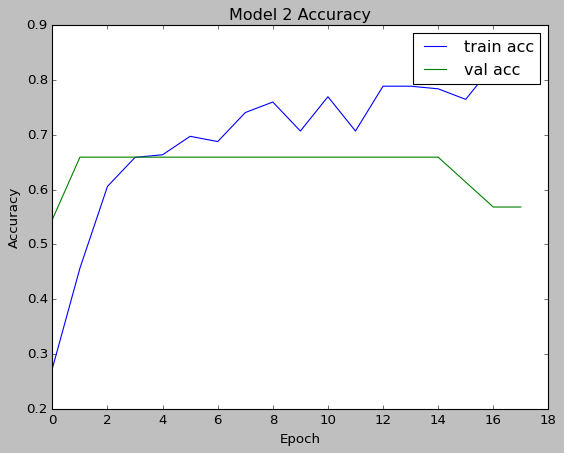

In [57]:
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 2 Accuracy')
plt.show()

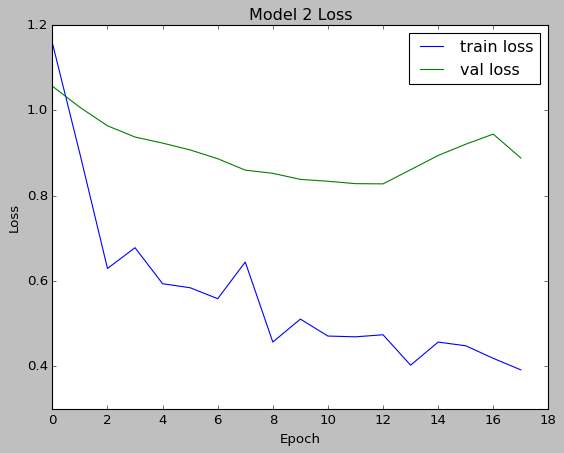

In [58]:
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 2 Loss')
plt.show()

Model 2 is an improvement over model 1, hitting a training ceiling at 0.6591 validation accuracy - liekly because model is predicting majority class

In [59]:
K.clear_session()

model3 = Sequential([
    Input(shape = (X_train_seq.shape[1],
                   X_train_seq.shape[2])),
    Bidirectional(LSTM(128,
                       return_sequences = True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64,
         return_sequences = True),
         BatchNormalization(),
         Dropout(0.3),

    LSTM(32,
         return_sequences = False),
         BatchNormalization(),
         Dropout(0.3),
         Dense(64,
               activation = 'relu'),
         Dropout(0.4),
         Dense(3,
               activation = 'softmax')])

model3.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [60]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

history3 = model3.fit(X_train_seq,
                      y_train_seq,
                      epochs = 50,
                      batch_size = 16,
                      validation_data = (X_test_seq,
                                         y_test_seq),
                      class_weight = class_weights,
                      callbacks=[early_stop])

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.1623 - loss: 1.4206 - val_accuracy: 0.6818 - val_loss: 1.0573
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2847 - loss: 1.0368 - val_accuracy: 0.7045 - val_loss: 0.9984
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4515 - loss: 0.7970 - val_accuracy: 0.6591 - val_loss: 0.9785
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6127 - loss: 0.6218 - val_accuracy: 0.6591 - val_loss: 0.9452
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6015 - loss: 0.6937 - val_accuracy: 0.6591 - val_loss: 0.9344
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6304 - loss: 0.6693 - val_accuracy: 0.6591 - val_loss: 0.9070
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6917 - loss: 0.5455 - val_accuracy: 0.6591 - val_loss: 0.8966
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7018 - loss: 0.5489 - val_accuracy: 0.6591 

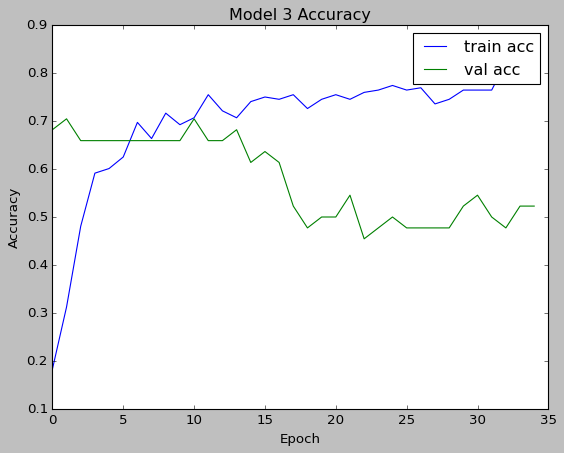

In [61]:
plt.plot(history3.history['accuracy'], label='train acc')
plt.plot(history3.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 3 Accuracy')
plt.show()

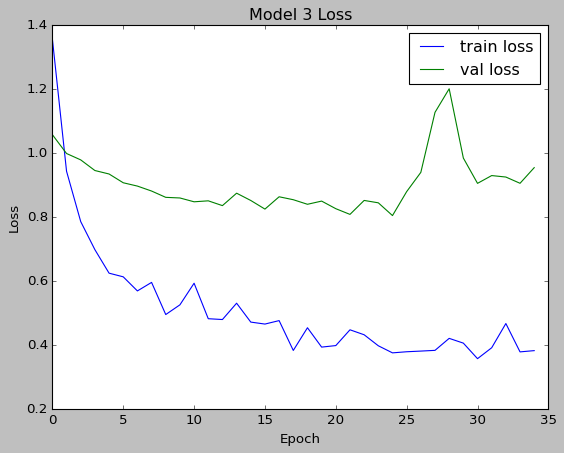

In [62]:
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 3 Loss')
plt.show()

or model 3 i increased the patience to 10 and added more epochs, but still stopping at 13 epochs. model is likely predicting majority class.

In [63]:
K.clear_session()

optimizer = Adam(learning_rate = 0.0005)

model4 = Sequential([Input(shape = (X_train_seq.shape[1],
                                    X_train_seq.shape[2])),
                           Bidirectional(LSTM(128,
                                              return_sequences = True)),
                           BatchNormalization(),
                           Dropout(0.3),
                           LSTM(64,
                                return_sequences = False),
                           BatchNormalization(),
                           Dropout(0.3),

                           Dense(64,
                                 activation = 'relu'),
                           Dropout(0.4),

                           Dense(3, activation = 'softmax')])

model4.compile(loss = 'categorical_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])



In [64]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)

history4 = model4.fit(X_train_seq,
                      y_train_seq,
                      epochs = 50,
                      batch_size = 32,
                      validation_data = (X_test_seq,
                                         y_test_seq),
                      class_weight = class_weights,
                      callbacks = [early_stop,
                                   reduce_lr])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.1133 - loss: 1.5696 - val_accuracy: 0.1818 - val_loss: 1.1442 - learning_rate: 5.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.2713 - loss: 1.0892 - val_accuracy: 0.2500 - val_loss: 1.1558 - learning_rate: 5.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3124 - loss: 0.9846 - val_accuracy: 0.2273 - val_loss: 1.1243 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3894 - loss: 0.9649 - val_accuracy: 0.2727 - val_loss: 1.0801 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4648 - loss: 0.7421 - val_accuracy: 0.5000 - val_loss: 1.0301 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.4810 - loss: 0.8021 - val_accuracy: 0.5455 - val_loss: 0.9893 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6361 - loss: 0.61

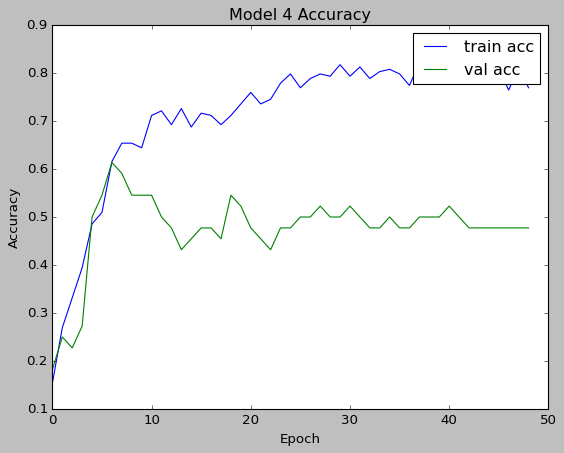

In [65]:
plt.plot(history4.history['accuracy'], label='train acc')
plt.plot(history4.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 4 Accuracy')
plt.show()


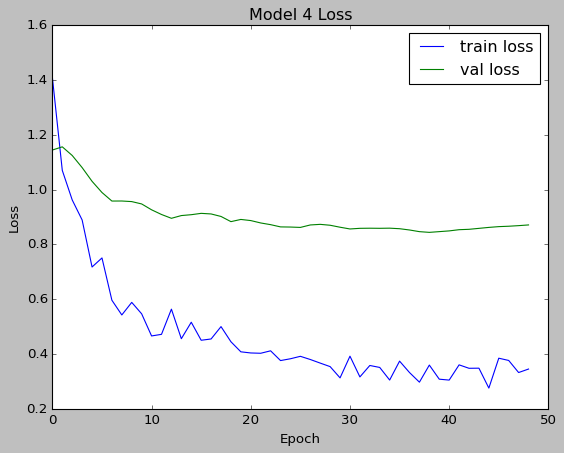

In [66]:
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 4 Loss')
plt.show()

## Walk forward validation

In [67]:
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

def walk_forward_validation(X, y, n_splits=5, time_steps=12, batch_size=32, epochs=50, class_weights=None):
    fold_size = len(X) // n_splits
    metrics = []
    min_sequence_length = time_steps + 1 # Minimum data points required to create one sequence

    for i in range(n_splits):
        print(f"\n=== Fold {i+1}/{n_splits} ===")

        # Define train and validation split
        train_end = fold_size * (i + 1)
        X_train_raw, y_train_raw = X[:train_end], y[:train_end]
        X_val_raw, y_val_raw = X[train_end:train_end + fold_size], y[train_end:train_end + fold_size]


        # Check if train and validation sets are large enough to create sequences
        if len(X_train_raw) < min_sequence_length or len(X_val_raw) < min_sequence_length:
            print(f"Skipping Fold {i+1}: Not enough data for sequence creation (need at least {min_sequence_length} samples in train and validation raw data).")
            continue

        # Create sequences
        def create_sequences(X, y, time_steps):
            Xs, ys = [], []
            # Ensure there is enough data to create at least one sequence
            if len(X) < time_steps + 1:
                return np.array([]), np.array([])
            for j in range(len(X) - time_steps):
                Xs.append(X[j:j + time_steps])
                ys.append(y[j + time_steps])
            return np.array(Xs), np.array(ys)


        X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
        X_val_seq, y_val_seq = create_sequences(X_val_raw, y_val_raw, time_steps)


        # Skip if sequences are empty after creation
        if len(X_train_seq) == 0 or len(X_val_seq) == 0:
            print(f"Skipping Fold {i+1}: Sequence creation resulted in empty arrays.")
            continue

        # Build model
        model = build_lstm_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        # Train
        history = model.fit(X_train_seq, y_train_seq,
                            validation_data=(X_val_seq, y_val_seq),
                            epochs=epochs,
                            batch_size=batch_size,
                            class_weight=class_weights,
                            callbacks=[early_stop, reduce_lr],
                            verbose=1)

        # Evaluate
        val_loss, val_accuracy = model.evaluate(X_val_seq, y_val_seq, verbose=0)
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        metrics.append(val_accuracy)

    if len(metrics) == 0:
        print("No folds had sufficient data for training.")
        return None

    print("\n=== Walk-forward validation results ===")
    print(f"Mean accuracy: {np.mean(metrics):.4f}, Std: {np.std(metrics):.4f}")
    return metrics

In [68]:
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [69]:
K.clear_session()

preds, true = walk_forward_validation(X_scaled, y_train, time_steps=6)


=== Fold 1/5 ===
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step - accuracy: 0.3114 - loss: 1.1270 - val_accuracy: 0.6327 - val_loss: 1.0055 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6437 - loss: 0.9047 - val_accuracy: 0.6939 - val_loss: 0.9521 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6229 - loss: 0.8361 - val_accuracy: 0.6735 - val_loss: 0.9230 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6437 - loss: 0.7647 - val_accuracy: 0.6531 - val_loss: 0.9072 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6541 - loss: 0.7413 - val_accuracy: 0.6531 - val_loss: 0.9001 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7022 - loss: 0.6780 - val_accuracy: 0.6327 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7262 - loss: 0.6513 - 

IndexError: index 6 is out of bounds for axis 0 with size 0

In [70]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


NameError: name 'history' is not defined

In [71]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

NameError: name 'history' is not defined

## Evaluation:

* Baseline: predict majority class = 77% accuracy. Can the model do better than that?
* Confusion matrix
* Accuracy
* F1 score
* Recall

## Discussion

What went wrong -  a lot! lets start with the data. there are very few observations, less than 300, probably not enough for a model to learn patterns. Finding historical data from the previous century (now that makes me feel old) would be time consuming.



## References

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/